# Gaussian Mixture Models

Given simple, well-separated data, k-means finds suitable clustering results. However, this method provide us with what we call 'hard assignment' which means that we say that this point belongs to one class or another. We have no idea how much how strong is this correlation.

The solution to that is stochastic method: Gaussian Mixture Models. A probabilistic approach to clustering addressing many of these problems. In this approach we describe each cluster by its centroid (mean), covariance , and the size of the cluster(Weight).

Here rather than identifying clusters by “nearest” centroids, we fit a set of k gaussians to the data. And we estimate gaussian distribution parameters such as mean and Variance for each cluster and weight of a cluster. After learning the parameters for each data point we can calculate the probabilities of it belonging to each of the clusters.

![alt text](https://qph.ec.quoracdn.net/main-qimg-e662c860801e26c6d1a41a7de35a7884-c "Logo Title Text 1")

To compute the solution we will use the Expectation-Maximisation algorithm:
1. E-step: Compute the posterior probability that each Gaussian generates (with current parameters) each data point
2. M-step: Assuming that the data really was generated this way, change the parameters of each Gaussian to maximize the probability that it would generate the data it is currently responsible for.


The general idea how the method works is presented below
![title](img/gaussian.jpg)

EM Steps
-----

1. Initialize the parameters θ
2. Compute the best values for Z given θ  
3. Use the computed values of Z to compute a better estimate for the θ  
4. Iterate steps 2 and 3 until convergence


Which in another words means:

1. Initialize the parameters of the models, either randomly or doing a "smart seeding"

2. E Step: Find the posterior probabilities of the latent variable given current parameter values.

3. M Step: Reestimate the parameter values given the current posterior probabilities.

4. Repeat 2-3 monitoring the likelihood function likelihood. Hope for convergence.

![alt text](http://i.imgur.com/0cTmOja.png "Logo Title Text 1")

![alt text](http://i.imgur.com/8kQ9aa6.png "Logo Title Text 1")

![alt text](http://i.imgur.com/A1j3lqB.png "Logo Title Text 1")

So the question now is how do we know that the EM updates improve things?
- Updating each Gaussian definitely improves the probability of generating the data if we generate it from the same Gaussians after the parameter updates.
- But we know that the posterior will change after updating the parameters.
- A good way to show that this is OK is to show that there is a single function that is improved by both the E-step and the M-step.
- This function is called Free Energy Q, one can prove (beyond the course) that EM will always improve this function

## Gaussian Mixture Models - Python Code

### 1D problem - one gaussian

In [2]:
reset -fs

In [3]:
# For plotting
import matplotlib.pyplot as plt
# for matrix math
import numpy as np
# for normalization + probability density function computation
from scipy import stats
# for plotting
import seaborn as sns
sns.set_style("white")
%matplotlib inline

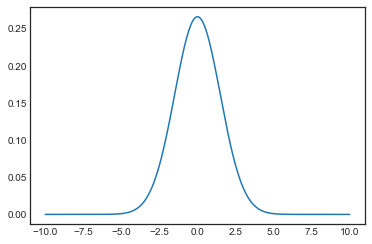

In [4]:
# Return evenly spaced numbers over a specified interval.
x = np.linspace(start=-10, stop=10, num=1000)
# A normal continuous random variable.
# The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
y = stats.norm.pdf(x, loc=0, scale=1.5) 
# plot it!
plt.plot(x, y)

In [8]:
# for data preprocessing
import pandas as pd

In [9]:
# read our dataset
df = pd.read_csv("bimodal_example.csv")
# show first 5 examples (in BTC)
df.head(n=5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


In [10]:
# show the distribution of the data as a histogram
data = df.x

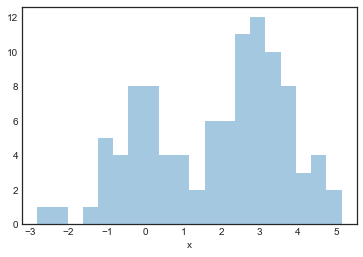

In [11]:
# plot histogram
sns.distplot(data, bins=20, kde=False)

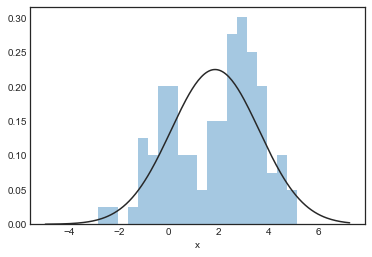

In [12]:
# try to fit a normal distribution to this data
sns.distplot(data, fit=stats.norm, bins=20, kde=False,)

### 1D problem - two gaussians

In [14]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    #printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [15]:
#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: μ = 1.9, σ = 1.8


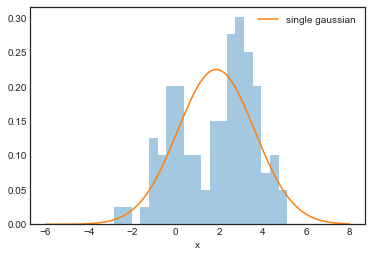

In [16]:
#fit a single gaussian curve to the data
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [17]:
from math import sqrt, log, exp, pi
from random import uniform

In [26]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.mix = mix

# Basically, you make initial guess for both the assignments of points
# to distributions and their parameters, and then proceed iteratively.
# Once you have initialized the assignments and parameters, you alternate
# between the expectation and maximization steps until your estiamtes 
# converge (i.e. do not change much between iterations; for a mixture of
# Gaussians this is similar to convergence in k-means)
        
        
    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [27]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

 1 Mixture: Gaussian(3.16323, 0.76879), Gaussian(0.0616534, 1.03392), mix=0.581)
 1 Mixture: Gaussian(3.11758, 0.812591), Gaussian(0.0397076, 1.05646), mix=0.592)
 1 Mixture: Gaussian(3.09699, 0.829318), Gaussian(0.0131684, 1.04661), mix=0.6)
 1 Mixture: Gaussian(3.08411, 0.838044), Gaussian(-0.0121254, 1.03009), mix=0.606)
 1 Mixture: Gaussian(3.07437, 0.843946), Gaussian(-0.0345217, 1.01349), mix=0.61)


In [28]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...



/home/marcin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()




Done. 🙂


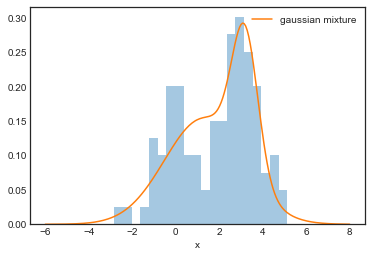

In [29]:
#mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();

### Note!

Due to the fact that Mixture Gaussians algorithm need more time and more computing power generally is good to:
1. Perform K-means clustering to find the centers of the data
2. Perform Gaussian Mixtures, however, instead of assigning random initial cluster centers - we use ones obtain from the K-means

### Summary
- Gaussian Mixture Models (GMM) take our old friend the Gaussian and add another Gaussian(s).
- This allows us to model more complex data.
- We fit a GMM with the Expectation–Maximization (EM) Algorithm.
- Expectation–Maximization (EM) Algorithm is a series of steps to find good parameter estimates when there are latent variables.
- EM steps:
    1. Initialize the parameter estimates
    2. Given the current parameter estimates, find the min log likelihood for Z (data+latent variables)
    3. Given the current data, find better parameter estimates
    4. Repeat steps 2 & 3
- EM can be used beyond GMM
- GMM work well but you have to guess the number of Gaussians. Kernel Density Estimation (KDE) does not require that kind of guessing


References:
1. https://medium.com/clustering-with-gaussian-mixture-model/clustering-with-gaussian-mixture-model-c695b6cd60da
2. https://www.youtube.com/watch?v=JNlEIEwe-Cg
3. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html